In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from spreg import OLS
import libpysal

import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=3, suppress=True)

#### Create DGP

In [2]:
# Simulate S1 and S2
def simulate_S1_S2(num_points1, num_points2): 
    np.random.seed(26) # set random seed
    
    locations1 = np.random.rand(num_points1, 2) * 100

    centers = [(30, 30), (70, 70), (30, 70), (70, 30)]  # Four clusters
    locations2, _ = make_blobs(n_samples=num_points2, centers=centers, cluster_std=10.0, random_state=26)

    locations2 = np.clip(locations2, 0, 100)

    s1 = np.random.normal(50, 10, num_points1)  # Target support observations
    s2 = np.random.normal(100, 50, num_points2) # Source support observations

    return s1, locations1, s2, locations2

S1, loc1, S2, loc2 = simulate_S1_S2(200, 350)

# Different beta surfaces to pick from

def create_uniform_surface(locations):
    B = np.ones(locations.shape[0]) * 20  # Constant beta value
    # B = locations[:, 0] / 10 + locations[:, 1] / 10
    # Alternatively, use a slight gradient: B = locations[:, 0] / 10 + locations[:, 1] / 10
    return B
                                    
def create_lineargradient_surface(locations):
    x = locations[:, 0]
    y = locations[:, 1]
    B = x + y  # True beta surface defined on target support S1
    return B

# Circular Beta Pattern
def create_circular_surface(locations, center=(50, 50), scale=1.0):
    # Compute the distance from each location to the center
    distances = np.sqrt((locations[:, 0] - center[0])**2 + (locations[:, 1] - center[1])**2)
    # Create a circular pattern, e.g., decreasing with distance
    B = np.exp(-distances / scale)
    return B

# Gaussian Random Field Beta Surface
def create_gaussian_random_field_surface(locations, length_scale=20.0, seed=42):
    np.random.seed(seed)
    # Use a Gaussian process to generate the field
    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel, random_state=seed)
    
    # Create the Gaussian random field by predicting on the grid
    B = gp.sample_y(locations, random_state=seed).flatten()
    return B

B = create_circular_surface(loc1)

# Number of neighbors for smoothing (DGP-specific)
n_neighbor_dgp = 35

smoothed_S2_to_S1 = np.zeros(len(S1))

# Use KNN to smooth X values from S2 onto S1
nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_dgp).fit(loc2)

for i in range(len(S1)):
    # Find neighbors of S1 location i in S2
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])

    # Aggregate the X values from S2 using a simple mean for the DGP (this is not the regression step)
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1  

### GWR-Change of Support-Functions

In [6]:
def calculate_aicc(n, rss, tr_S):
    """
    Calculate AICc with penalization term based on the trace of the hat matrix.

    Parameters:
    - n: Number of observations
    - rss: Residual sum of squares
    - tr_S: Trace of the hat matrix (effective number of parameters)

    Returns:
    - AICc value
    """
    sigma2 = rss / n
    aic = n * np.log(sigma2) + 2 * (tr_S + 1)
    if (n - tr_S - 2) > 0:
        aicc = aic + (2 * tr_S * (tr_S + 1)) / (n - tr_S - 2)
    else:
        aicc = np.inf  # Prevent division by zero or negative values
    return aicc
    
def perform_local_regression(n_neighbor_est, loc1, loc2, S2, y):
    """
    Function to estimate a local regression that incorporates change of support
    """
    
    recovered_betas = np.zeros(len(S1))
    aicc_values = []  # Store location-specific AICc values

    for i in range(len(S1)):
        local_X = []
        weights_X = []
        
        nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
        
        for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
            dist_j_to_i = distances_S1_to_S2[0][j]  
            weight = np.exp(-0.5 * (dist_j_to_i / 10)**2)
            local_X.append(S2[neighbor_index_S2])
            weights_X.append(weight)
        
        local_X = np.array(local_X)
        weights_X = np.array(weights_X)
        weighted_X_i = np.sum(local_X * weights_X) / np.sum(weights_X)

        nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)
        distances, indices = nbrs_S1.kneighbors([loc1[i]])

        y_neighbors = y[indices[0]]
        X_neighbors = weighted_X_i * np.ones(len(indices[0]))
        weights_y = np.exp(-0.5 * (distances[0] / 10)**2)  
        W_y = np.sqrt(weights_y)
        

        X_weighted = (X_neighbors * W_y).reshape(-1, 1)
        y_weighted = y_neighbors * W_y

        # Fit OLS using PySAL spreg OLS
        model = OLS(y_weighted, np.hstack([np.ones((len(X_weighted), 1)), X_weighted]))

        # Construct the hat matrix S
        X_design = np.hstack([np.ones((len(X_weighted), 1)), X_weighted])
        hat_matrix = X_design @ np.linalg.inv(X_design.T @ X_design) @ X_design.T

        # Calculate location-specific AICc
        rss = np.sum((y_weighted - model.predy.flatten()) ** 2)
        tr_S = np.trace(hat_matrix)
        aicc = calculate_aicc(len(y_weighted), rss, tr_S)

        aicc_values.append(aicc)

        # Use coefficients from the model
        recovered_beta = model.betas[1, 0]  # Explicitly extract the scalar value from 2D array
        recovered_betas[i] = recovered_beta

    # Aggregate location-specific AICc values 
    overall_aicc = np.nanmean(aicc_values)  
    
    return recovered_betas, overall_aicc

def objective_function(k, loc1, loc2, S2, y):
    k = int(k)  # Ensure k is an integer
    _, aicc = perform_local_regression(n_neighbor_est=k, loc1=loc1, loc2=loc2, S2=S2, y=y)
    return aicc

# Define the range for k values
k_min, k_max = 2, 200  # search the whole extent of the data. has 200 observations

# Brute force search for the optimal k
best_k = None
best_aicc = float('inf')

aicc_values_for_k = []

for k in range(k_min, k_max + 1, 10):
    aicc = objective_function(k, loc1, loc2, S2, y)
    aicc_values_for_k.append(aicc)
    if aicc < best_aicc:
        best_aicc = aicc
        best_k = k

print("")
print(f"Optimal k: {best_k}")



Optimal k: 192


### Visualize 

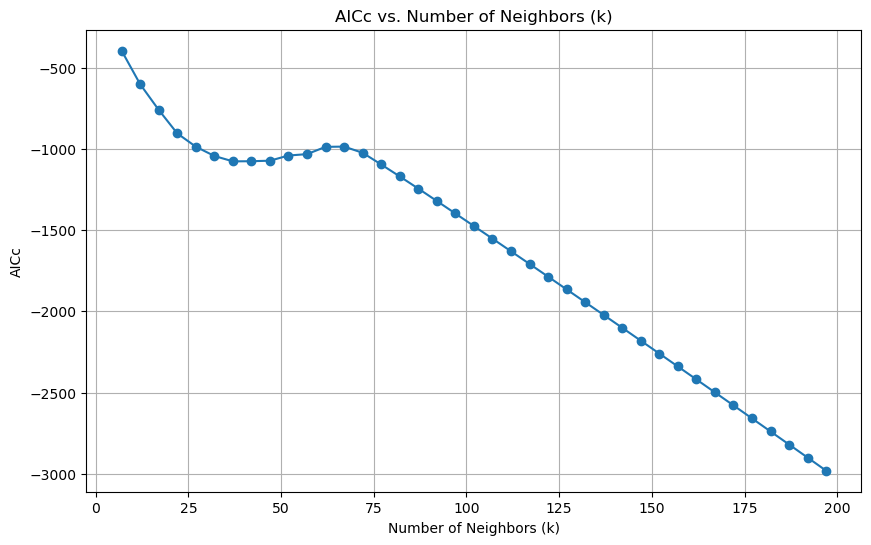

In [4]:
# Lists to store k values and their corresponding AICc values
k_values = list(range(2, 200, 5))
aicc_values_for_k = []

# Brute force search for the optimal k and collect AICc values
for k in k_values:
    aicc = objective_function(k, loc1, loc2, S2, y)
    aicc_values_for_k.append(aicc)

# Plotting AICc vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, aicc_values, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors (k)')
plt.grid(True)
plt.show()


In [5]:
list(zip(k_values, aicc_values))

[(2, inf),
 (7, -396.38143808805586),
 (12, -602.5671244132387),
 (17, -760.5448225326692),
 (22, -905.1520259237815),
 (27, -986.9165189937354),
 (32, -1044.021871520239),
 (37, -1077.2015754329238),
 (42, -1076.390430257138),
 (47, -1073.1305690373258),
 (52, -1041.3698695894777),
 (57, -1032.683691154512),
 (62, -987.9935608189166),
 (67, -986.4083654855981),
 (72, -1024.537478486604),
 (77, -1096.4506489989615),
 (82, -1170.008408055852),
 (87, -1244.8264945871572),
 (92, -1321.044027078817),
 (97, -1398.0206265888532),
 (102, -1475.2683109781717),
 (107, -1552.7727280407346),
 (112, -1630.5203261886647),
 (117, -1708.4990248297195),
 (122, -1786.6979467067424),
 (127, -1865.107257488183),
 (132, -1943.7180365314853),
 (137, -2022.5221583620971),
 (142, -2101.5121393991353),
 (147, -2180.681077869275),
 (152, -2260.0225934819655),
 (157, -2339.5307955706803),
 (162, -2419.2001875484048),
 (167, -2499.025623958065),
 (172, -2579.0023003356114),
 (177, -2659.1256955974636),
 (182, -2

### Re-running the code using beta with uniform surface

In [7]:
B = create_uniform_surface(loc1)

# Number of neighbors for smoothing (DGP-specific)
n_neighbor_dgp = 35

smoothed_S2_to_S1 = np.zeros(len(S1))

# Use KNN to smooth X values from S2 onto S1
nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_dgp).fit(loc2)

for i in range(len(S1)):
    # Find neighbors of S1 location i in S2
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])

    # Aggregate the X values from S2 using a simple mean for the DGP (this is not the regression step)
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1  

#### Change of support gwr functions

In [ ]:
def calculate_aicc(n, rss, tr_S):
    """
    Calculate AICc with penalization term based on the trace of the hat matrix.

    Parameters:
    - n: Number of observations
    - rss: Residual sum of squares
    - tr_S: Trace of the hat matrix (effective number of parameters)

    Returns:
    - AICc value
    """
    sigma2 = rss / n
    aic = n * np.log(sigma2) + 2 * (tr_S + 1)
    if (n - tr_S - 2) > 0:
        aicc = aic + (2 * tr_S * (tr_S + 1)) / (n - tr_S - 2)
    else:
        aicc = np.inf  # Prevent division by zero or negative values
    return aicc
    
def perform_local_regression(n_neighbor_est, loc1, loc2, S2, y):
    """
    Function to estimate a local regression that incorporates change of support
    """
    
    recovered_betas = np.zeros(len(S1))
    aicc_values = []  # Store location-specific AICc values

    for i in range(len(S1)):
        local_X = []
        weights_X = []
        
        nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
        
        for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
            dist_j_to_i = distances_S1_to_S2[0][j]  
            weight = np.exp(-0.5 * (dist_j_to_i / 10)**2)
            local_X.append(S2[neighbor_index_S2])
            weights_X.append(weight)
        
        local_X = np.array(local_X)
        weights_X = np.array(weights_X)
        weighted_X_i = np.sum(local_X * weights_X) / np.sum(weights_X)

        nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)
        distances, indices = nbrs_S1.kneighbors([loc1[i]])

        y_neighbors = y[indices[0]]
        X_neighbors = weighted_X_i * np.ones(len(indices[0]))
        weights_y = np.exp(-0.5 * (distances[0] / 10)**2)  
        W_y = np.sqrt(weights_y)
        

        X_weighted = (X_neighbors * W_y).reshape(-1, 1)
        y_weighted = y_neighbors * W_y

        # Fit OLS using PySAL spreg OLS
        model = OLS(y_weighted, np.hstack([np.ones((len(X_weighted), 1)), X_weighted]))

        # Construct the hat matrix S
        X_design = np.hstack([np.ones((len(X_weighted), 1)), X_weighted])
        hat_matrix = X_design @ np.linalg.inv(X_design.T @ X_design) @ X_design.T

        # Calculate location-specific AICc
        rss = np.sum((y_weighted - model.predy.flatten()) ** 2)
        tr_S = np.trace(hat_matrix)
        aicc = calculate_aicc(len(y_weighted), rss, tr_S)

        aicc_values.append(aicc)

        # Use coefficients from the model
        recovered_beta = model.betas[1, 0]  # Explicitly extract the scalar value from 2D array
        recovered_betas[i] = recovered_beta

    # Aggregate location-specific AICc values 
    overall_aicc = np.nanmean(aicc_values)  
    
    return recovered_betas, overall_aicc

def objective_function(k, loc1, loc2, S2, y):
    k = int(k)  # Ensure k is an integer
    _, aicc = perform_local_regression(n_neighbor_est=k, loc1=loc1, loc2=loc2, S2=S2, y=y)
    return aicc

# Define the range for k values
k_min, k_max = 2, 200  # search the whole extent of the data. has 200 observations

# Brute force search for the optimal k
best_k = None
best_aicc = float('inf')

aicc_values_for_k1 = []

for k in range(k_min, k_max + 1, 2):
    aicc = objective_function(k, loc1, loc2, S2, y)
    aicc_values_for_k1.append(aicc)
    if aicc < best_aicc:
        best_aicc = aicc
        best_k = k

print("")
print(f"Optimal k: {best_k}")


In [ ]:
# Lists to store k values and their corresponding AICc values
k_values1 = list(range(2, 20, 2))
aicc_values_for_k1 = []

# Brute force search for the optimal k and collect AICc values
for k in k_values1:
    aicc = objective_function(k, loc1, loc2, S2, y)
    aicc_values_for_k1.append(aicc)

# Plotting AICc vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values1, aicc_values_for_k1, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors (k)')
plt.grid(True)
plt.show()


In [ ]:
list(zip(k_values1, aicc_values_for_k1))